# IMDB: MLM Insertion

In [1]:
import json
import heapq
import os
import random
from typing import List

%pip install -U datasets
%pip install transformers
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader
from transformers import AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


plt.style.use('fivethirtyeight')

ROOT_DIR = "drive/My Drive/Colab Notebooks/nlp/results/imdb_mlm_insertion"
if not os.path.exists(ROOT_DIR):
    os.mkdir(ROOT_DIR)

     |████████████████████████████████| 153kB 4.5MB/s 
     |████████████████████████████████| 17.7MB 199kB/s 
     |████████████████████████████████| 245kB 49.1MB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 890kB 13.8MB/s 
     |████████████████████████████████| 2.9MB 30.3MB/s 
     |████████████████████████████████| 1.1MB 45.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f4f1f487f7e563be81c28e297c8df93dc5e9d891024750978d2fdead09ec6558
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


## Defining augmentation function

In [ ]:
class MLMInsertionAugmenter:
    def __init__(self, model, tokenizer, p: float, min_mask: int = 1, max_mask: int = 100, topk: int = 5, uniform: bool = False, device=None):
        self.device = device or torch.device('cpu')
        self.model = model.eval().to(self.device)
        self.tokenizer = tokenizer
        self.vocab_words = list(tokenizer.get_vocab().keys())
        self.mask_token = tokenizer.mask_token
        self.mask_token_id = tokenizer.mask_token_id
        self.topk = topk
        self.min_mask = min_mask
        self.max_mask = max_mask
        self.uniform = uniform
        self.p = p
        

    def __call__(self, text: str):
        if self.p == 0:
            return text
        words = np.array(text.split(), dtype='object')
        n_mask = max(self.min_mask, int(len(words) * self.p))
        n_mask = min(n_mask, self.max_mask)
        max_masked_idx = min(self.tokenizer.model_max_length // 2 - n_mask, len(words) + 1)  # offset, since lenght might increase after tokenization
        # end of the long text won't be augmented, but I guess we can live with that
        masked_indices = np.sort(np.random.choice(max_masked_idx, size=n_mask, replace=False))
        masked_words = np.insert(words, masked_indices, self.mask_token)
        masked_text = " ".join(masked_words)
        
        tokenizer_output = self.tokenizer([masked_text], truncation=True)
        input_ids = torch.tensor(tokenizer_output['input_ids']).to(self.device)
        attention_mask = torch.tensor(tokenizer_output['attention_mask']).to(self.device)
        with torch.no_grad():
            output = self.model(input_ids)
            predicted_logits = output.logits[input_ids == self.mask_token_id]
            predicted_probas = predicted_logits.softmax(1)
            
        predicted_words = [self.sample_word(probas).strip() for probas in predicted_probas]
        
        new_words = np.insert(words, masked_indices, predicted_words)
        new_text = " ".join(new_words)
        return new_text
    
    
    def sample_word(self, predicted_probas):
        if hasattr(predicted_probas, 'tolist'):
            predicted_probas = predicted_probas.tolist()
        most_probable = heapq.nlargest(self.topk, zip(self.vocab_words, predicted_probas),  key=lambda t: t[1])
        words, probas = zip(*most_probable)
        word = random.choice(words) if self.uniform else random.choices(words, weights=probas)[0]
        return self.tokenizer.convert_tokens_to_string(word).strip()

In [ ]:
class DatasetWithAugmentation(torch.utils.data.Dataset):
    def __init__(self, dataset, augmenter, augmentation_prob: float = 0.9):
        self.dataset = dataset
        self.augmenter = augmenter
        self.augmentation_prob = augmentation_prob

    def __getitem__(self, i):
        try:
            item = self.dataset[i]
            if random.random() < self.augmentation_prob:
                item['text'] = self.augmenter(item['text'])
            return item
        except:
            print(item)
            raise Exception(f"Something went wrong when augmenting item number {i}")

    def __len__(self):
        return len(self.dataset)


def get_datasets(dataset_name, augmenter, train_size, val_size=5_000, test_size=None, augmentation_prob=0.5, random_seed: int = 42):
    dataset = load_dataset(dataset_name, split="train")
    test_dataset = load_dataset(dataset_name, split="test")
    # We want test and validation data to be the same for every experiment
    if test_size:
        test_dataset = test_dataset.train_test_split(test_size=test_size, seed=random_seed)["test"]
    train_val_split = dataset.train_test_split(test_size=val_size, seed=random_seed)
    # Validation and test sets
    train_dataset = train_val_split["train"].train_test_split(train_size=train_size, seed=random_seed)["train"]
    train_dataset = DatasetWithAugmentation(train_dataset, augmenter, augmentation_prob=augmentation_prob)
    val_dataset = train_val_split["test"]
    return train_dataset, val_dataset, test_dataset


class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        
    def __call__(self, examples: List[dict]):
        labels = [example['label'] for example in examples]
        texts = [example['text'] for example in examples]
        tokenizer_output = self.tokenizer(texts, truncation=True, padding=True)
        return {
            'labels': torch.tensor(labels), 
            'input_ids': torch.tensor(tokenizer_output['input_ids']), 
            'attention_mask': torch.tensor(tokenizer_output['attention_mask'])
            }


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
AUGMENTATION_PROB = 0.6

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=False)  # we cannot use Fast tokenizer for MLMInsertionAugmenter
data_collator = DataCollator(tokenizer)

device = torch.device('cuda')
mlm_model = AutoModelForMaskedLM.from_pretrained('roberta-base', return_dict=True).eval().to(device)

Some weights of RobertaForMaskedLM were not initialized from the model checkpoint at roberta-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, 0.2, min_mask=1, topk=10, uniform=False, device=torch.device('cuda'))

In [ ]:
augmenter('I love you ')

'I really love you'

In [ ]:
train_size = 100


FRACTIONS = [0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
accuracies = list()

for fraction in FRACTIONS:

    model = AutoModelForSequenceClassification.from_pretrained('roberta-base', return_dict=True)
    augmenter = MLMInsertionAugmenter(mlm_model, tokenizer, fraction, min_mask=1, topk=10, uniform=False, device=device)

    train_dataset, val_dataset, test_dataset = get_datasets("imdb", augmenter, train_size, val_size=1_000, test_size=5_000, augmentation_prob=AUGMENTATION_PROB)
    print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")
    print(f"Augmentation fraction: {fraction}")
    print(train_dataset[0])
    print(val_dataset[0])
    print(test_dataset[0])
    output_dir = os.path.join(ROOT_DIR, f"train_size_{train_size}_augmentation_fraction_{fraction}")

    num_train_epochs = 8  # 6 is ideal for 100 samples, convergence point

    # https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments
    training_args = TrainingArguments(
        learning_rate=3e-5,
        weight_decay=0.01,
        output_dir=output_dir,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=2,
        warmup_steps=0,  # don't have any intuition for the right value here
        logging_dir=output_dir,
        logging_steps=5,
        load_best_model_at_end=False,
        evaluation_strategy='epoch',
        remove_unused_columns=False,
        no_cuda=False,
        metric_for_best_model="eval_accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
        
    )

    trainer.train()

    test_result = trainer.evaluate(test_dataset)

    print(test_result)
    accuracies.append(test_result['eval_accuracy'])

    with open(os.path.join(output_dir, 'test_result.json'), 'w') as f:
        json.dump(test_result, f, indent=4)

    print()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0
{'label': 0, 'text': "A complete waste of time<br /><br />Halla Bol is a complete waste of time. The script and dialogues are poorly written, the direction is lacklustre and the acting borders on hammy.This movie was clearly aiming for the Rang De Basanti crowd but it falls far short of the mark because it does not have even one of the elements that made RDB connect with its audience_great script, terrific acting, good direction and a powerful social message that was never preached but shown.<br /><br />Compared to that near-masterpiece, Halla Bol takes a step backwards by resorting to scenes such as the hero taking a leak on the villain's Persian rug and the hero's mentor staring down bullets in a truck no less! All of this might have been acceptable in the 80s when there was a downturn in movie quality and bad movies like DivyaShakti and Phool Aur Kaante became big hits, but movie-making has become_shoul

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.716219,0.687837,0.492000,0.015504,1.000000,0.007812
1,0.748208,0.691555,0.488000,0.000000,0.000000,0.000000
2,0.739509,0.598468,0.605000,0.387597,0.939850,0.244141
3,0.611929,0.462080,0.827000,0.811341,0.918519,0.726562
4,0.305582,0.351154,0.883000,0.887824,0.871940,0.904297
5,0.204962,0.348863,0.890000,0.889113,0.918750,0.861328
6,0.078436,0.364418,0.871000,0.883679,0.820771,0.957031
7,0.041603,0.360705,0.883000,0.892955,0.839931,0.953125


{'eval_loss': 0.3758549690246582, 'eval_accuracy': 0.8734, 'eval_f1': 0.8815715622076706, 'eval_precision': 0.8263767099263416, 'eval_recall': 0.9446672012830793, 'epoch': 7.923076923076923, 'total_flos': 275609850530400}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.01
{'label': 0, 'text': "A complete waste of time<br /><br - />Halla Bol is a complete waste of time. The script and dialogues are poorly written, the direction is lacklustre and the acting borders on hammy.This movie was clearly aiming for the Rang De Basanti crowd but it falls far short of the mark because it does not have even one of the elements that made RDB connect with its audience_great script, terrific acting, good direction and a powerful social message that was never just preached but shown.<br /><br />Compared to that near-masterpiece, Halla Bol takes a step backwards by resorting to scenes such as the hero taking a leak on the villain's Persian rug and the hero's mentor staring down bullets in a truck no less! All of this might have been acceptable in the 80s when there was a downturn in movie quality and bad movies like DivyaShakti and Phool Aur Kaante became big hits, but movie-making has be

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.698254,0.691330,0.488000,0.000000,0.000000,0.000000
1,0.726529,0.703574,0.488000,0.000000,0.000000,0.000000
2,0.679125,0.587439,0.707000,0.649102,0.839009,0.529297
3,0.651515,0.391155,0.875000,0.870197,0.929047,0.818359
4,0.246741,0.375480,0.866000,0.880357,0.810855,0.962891
5,0.131075,0.318171,0.894000,0.895050,0.907631,0.882812
6,0.067896,0.358716,0.887000,0.895853,0.848168,0.949219
7,0.035709,0.399097,0.885000,0.894204,0.845217,0.949219


{'eval_loss': 0.40014761686325073, 'eval_accuracy': 0.8806, 'eval_f1': 0.8881813073609289, 'eval_precision': 0.8333919156414763, 'eval_recall': 0.9506816359262229, 'epoch': 7.923076923076923, 'total_flos': 275932935995040}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.1
{'label': 0, 'text': "A complete waste of time<br /><br />Halla Bol is a complete waste of time. The script and dialogues are poorly written, the direction is lacklustre and the acting borders on hammy.This movie was clearly aiming for the Rang De Basanti crowd but it falls far short of the mark because it does not have even one of the elements that made RDB connect with its audience_great script, terrific acting, good direction and a powerful social message that was never preached but shown.<br /><br />Compared to that near-masterpiece, Halla Bol takes a step backwards by resorting to scenes such as the hero taking a leak on the villain's Persian rug and the hero's mentor staring down bullets in a truck no less! All of this might have been acceptable in the 80s when there was a downturn in movie quality and bad movies like DivyaShakti and Phool Aur Kaante became big hits, but movie-making has become_sho

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.705301,0.696263,0.488000,0.000000,0.000000,0.000000
1,0.741379,0.703639,0.488000,0.000000,0.000000,0.000000
2,0.725265,0.628018,0.575000,0.299835,0.957895,0.177734
3,0.663722,0.374893,0.889000,0.889552,0.906694,0.873047
4,0.228510,0.312640,0.889000,0.890640,0.898608,0.882812
5,0.151600,0.320074,0.885000,0.889317,0.876660,0.902344
6,0.065260,0.380225,0.884000,0.893382,0.843750,0.949219
7,0.027648,0.388671,0.883000,0.891767,0.847100,0.941406


{'eval_loss': 0.36623984575271606, 'eval_accuracy': 0.8894, 'eval_f1': 0.8951261141665087, 'eval_precision': 0.8492263404102195, 'eval_recall': 0.946271050521251, 'epoch': 7.923076923076923, 'total_flos': 279531749087280}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.15
{'label': 0, 'text': ": A complete waste of time<br /><br />Halla Bol is simply a complete waste of of time. The script and the dialogues are poorly written, the direction is extremely lacklustre and the acting borders on hammy.This movie was clearly aiming for pleasing the Rang De Basanti crowd but it falls far far short of the mark because it does , not possible have even half one of the elements that made The RDB movie connect with its audience_great script, terrific acting, a good direction and a powerful social message and that message was never preached , but shown.<br /><br />Compared to even that was near-masterpiece, Halla Bol takes a major step backwards by resorting to scenes such as depicting the hero accidentally taking out a gas leak on the villain's Persian rug and showing the dead hero's young mentor staring down bullets in a truck no less! All of this stuff might have once been acceptab

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.692519,0.689372,0.511000,0.089385,0.960000,0.046875
1,0.738916,0.698189,0.488000,0.000000,0.000000,0.000000
2,0.712880,0.620709,0.625000,0.444444,0.920245,0.292969
3,0.643131,0.480913,0.817000,0.793687,0.938667,0.687500
4,0.297647,0.328625,0.886000,0.891635,0.868519,0.916016
5,0.149837,0.351106,0.884000,0.887160,0.883721,0.890625
6,0.069949,0.422724,0.868000,0.878676,0.829861,0.933594
7,0.023939,0.468808,0.864000,0.876812,0.817568,0.945312


{'eval_loss': 0.4674531817436218, 'eval_accuracy': 0.86, 'eval_f1': 0.871086556169429, 'eval_precision': 0.8055177111716622, 'eval_recall': 0.9482758620689655, 'epoch': 7.923076923076923, 'total_flos': 282101475144000}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.2
{'label': 0, 'text': "A complete waste of time<br / /><br />Halla De Bol 2 is also a complete bloody waste of time. The entire script lines and dialogues are all poorly well written, both the art direction itself is utterly lacklustre and the acting borders on the hammy.This entire movie was very clearly made aiming goal for the Rang De De Basanti crowd but it still falls far short short of the mark because it simply does not really have even one of the elements that made the RDB B connect easily with its target audience_great script, a terrific voice acting, good direction , and a powerful and social message that perhaps was never just preached but shown.<br /><br />Compared with to that original near-masterpiece, Halla Na Bol takes quite a step step backwards by resorting to scenes with such scenes as , the hero of taking out a water leak on the villain's Persian rug and the young hero's mentor , stari

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.709064,0.691909,0.488000,0.000000,0.000000,0.000000
1,0.734651,0.693015,0.488000,0.000000,0.000000,0.000000
2,0.711291,0.592831,0.655000,0.516129,0.915423,0.359375
3,0.629284,0.352925,0.885000,0.888023,0.885437,0.890625
4,0.223077,0.335087,0.878000,0.882012,0.873563,0.890625
5,0.133890,0.333805,0.890000,0.895238,0.873606,0.917969
6,0.050578,0.384900,0.875000,0.885636,0.833046,0.945312
7,0.033046,0.372199,0.888000,0.894539,0.863636,0.927734


{'eval_loss': 0.3598524034023285, 'eval_accuracy': 0.8866, 'eval_f1': 0.8904347826086957, 'eval_precision': 0.8593808280492353, 'eval_recall': 0.9238171611868484, 'epoch': 7.923076923076923, 'total_flos': 283348944021360}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.25
{'label': 0, 'text': "A complete waste of time<br /><br />Halla Bol is a complete waste of time. The script and dialogues are poorly written, the direction is lacklustre and the acting borders on hammy.This movie was clearly aiming for the Rang De Basanti crowd but it falls far short of the mark because it does not have even one of the elements that made RDB connect with its audience_great script, terrific acting, good direction and a powerful social message that was never preached but shown.<br /><br />Compared to that near-masterpiece, Halla Bol takes a step backwards by resorting to scenes such as the hero taking a leak on the villain's Persian rug and the hero's mentor staring down bullets in a truck no less! All of this might have been acceptable in the 80s when there was a downturn in movie quality and bad movies like DivyaShakti and Phool Aur Kaante became big hits, but movie-making has become_sh

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.694185,0.687053,0.538000,0.683562,0.526371,0.974609
1,0.760804,0.695415,0.488000,0.000000,0.000000,0.000000
2,0.735540,0.669448,0.571000,0.290909,0.946237,0.171875
3,0.703163,0.549109,0.774000,0.747768,0.872396,0.654297
4,0.348930,0.342851,0.883000,0.882883,0.905544,0.861328
5,0.188915,0.299791,0.894000,0.897683,0.887405,0.908203
6,0.110460,0.356593,0.874000,0.884826,0.831615,0.945312
7,0.073904,0.336830,0.890000,0.896030,0.868132,0.925781


{'eval_loss': 0.3488401174545288, 'eval_accuracy': 0.8838, 'eval_f1': 0.888505085396277, 'eval_precision': 0.8520426941479573, 'eval_recall': 0.9282277465918204, 'epoch': 7.923076923076923, 'total_flos': 285754135813680}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.3
{'label': 0, 'text': "A complete waste of time<br /><br />Halla Bol is a complete waste of time. The script and dialogues are poorly written, the direction is lacklustre and the acting borders on hammy.This movie was clearly aiming for the Rang De Basanti crowd but it falls far short of the mark because it does not have even one of the elements that made RDB connect with its audience_great script, terrific acting, good direction and a powerful social message that was never preached but shown.<br /><br />Compared to that near-masterpiece, Halla Bol takes a step backwards by resorting to scenes such as the hero taking a leak on the villain's Persian rug and the hero's mentor staring down bullets in a truck no less! All of this might have been acceptable in the 80s when there was a downturn in movie quality and bad movies like DivyaShakti and Phool Aur Kaante became big hits, but movie-making has become_sho

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.695967,0.688265,0.569000,0.527930,0.600998,0.470703
1,0.735515,0.693479,0.489000,0.003899,1.000000,0.001953
2,0.725423,0.640239,0.637000,0.502058,0.843318,0.357422
3,0.681234,0.463978,0.835000,0.823906,0.908235,0.753906
4,0.321624,0.366354,0.856000,0.870968,0.804636,0.949219
5,0.199695,0.340217,0.878000,0.874227,0.925764,0.828125
6,0.136621,0.315313,0.885000,0.892221,0.857658,0.929688
7,0.109499,0.316525,0.885000,0.891612,0.861566,0.923828


{'eval_loss': 0.3144931495189667, 'eval_accuracy': 0.8848, 'eval_f1': 0.8885880077369439, 'eval_precision': 0.8583707025411061, 'eval_recall': 0.9210104250200482, 'epoch': 7.923076923076923, 'total_flos': 288267022760880}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.4
{'label': 0, 'text': "| A near complete utter waste out of its time<br / /><br />Halla De Bol , is just a near complete colossal waste waste of its time. There The lackluster script and the dialogues alone are all poorly written, the camera direction itself is lacklustre , and the supporting acting style borders en on hammy.This was movie that was clearly aiming out for for the mainstream Rang 's De Re Basanti crowd , but actually it falls so far short of the mark is because all it really does is not even have achieved even one one of the core elements that it made the RDB movie connect with with its audience_great written script, a terrific character acting, good direction , and also a powerful , social good message , that it was simply never being preached about but shown.<br /><br br />Compared to even that near-masterpiece, here Halla Bol takes is a step backwards by only resorting merely to unnecess

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.695338,0.689194,0.518000,0.117216,0.941176,0.062500
1,0.731576,0.708201,0.488000,0.000000,0.000000,0.000000
2,0.736680,0.570711,0.828000,0.824131,0.864807,0.787109
3,0.605769,0.331316,0.882000,0.885214,0.881783,0.888672
4,0.155972,0.318298,0.892000,0.895551,0.886973,0.904297
5,0.103222,0.365906,0.893000,0.899341,0.867514,0.933594
6,0.037498,0.384570,0.894000,0.896887,0.893411,0.900391
7,0.065141,0.433754,0.884000,0.884462,0.902439,0.867188


{'eval_loss': 0.4064241349697113, 'eval_accuracy': 0.8912, 'eval_f1': 0.8893409275834012, 'eval_precision': 0.902559867877787, 'eval_recall': 0.8765036086607859, 'epoch': 7.923076923076923, 'total_flos': 290256391594080}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.5
{'label': 0, 'text': "A near complete waste of your time<br / /><br / />Halla De Bol , is simply a a complete and waste out of my time. There The entire script and dialogues , are poorly written, and the film direction too is lacklustre , and the acting quality borders on on hammy.This one movie that was clearly the aiming goal for reaching the Rang 's De Da Basanti crowd , but unfortunately it still falls far far short short of hitting the right mark because when it , does not really have a even a one hundred of the core elements that that made RDB B connect well with its intended audience_great written script, a terrific acting, good art direction and even a very powerful and social message , that message was never preached upon but shown.<br / /><br / />Compared just to its that near-masterpiece, here Halla Bol takes us a huge step backwards by resorting to boring scenes with such moments as the hero 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.714047,0.693319,0.488000,0.000000,0.000000,0.000000
1,0.741185,0.707702,0.488000,0.000000,0.000000,0.000000
2,0.712967,0.546726,0.766000,0.719424,0.931677,0.585938
3,0.583515,0.313443,0.889000,0.892546,0.884837,0.900391
4,0.145199,0.311798,0.882000,0.887619,0.866171,0.910156
5,0.106202,0.396843,0.884000,0.880412,0.932314,0.833984
6,0.120908,0.381148,0.888000,0.891683,0.883142,0.900391
7,0.063165,0.391337,0.887000,0.889971,0.887379,0.892578


{'eval_loss': 0.3604607880115509, 'eval_accuracy': 0.8942, 'eval_f1': 0.8942634419348391, 'eval_precision': 0.8915902750099641, 'eval_recall': 0.896952686447474, 'epoch': 7.923076923076923, 'total_flos': 290017069027680}



Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Train size: 100, Validation size: 1000, Test size: 5000
Augmentation fraction: 0.6
{'label': 0, 'text': ": A complete waste of time<br /><br / />Halla Ko Bol 2 is a very complete , waste out of time. The terrible script , and the dialogues , are poorly well written, the acting direction is extremely lacklustre quality and frankly the poor acting borders in on the hammy.This is movie which was clearly an aiming point for the Rang 's De Basanti review crowd but it ultimately falls so far far short of of hitting the mark simply because what it does , not even have been even one one one of all the very elements which that made that RDB connect well with all its intended audience_great script, terrific acting, good direction and a very powerful , social message that it was to never just preached upon but rather shown.<br /><br / />Compared to that near-masterpiece, the Halla Ka Bol takes is a big step backwards , by often resorting only to stupid scenes , such as the hero accidentally takin

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,0.712571,0.689451,0.559000,0.275862,0.865979,0.164062
1,0.743604,0.700167,0.488000,0.000000,0.000000,0.000000
2,0.730907,0.643200,0.559000,0.246154,0.986301,0.140625
3,0.638660,0.404929,0.871000,0.873405,0.877712,0.869141
4,0.215413,0.355479,0.872000,0.871227,0.898340,0.845703
5,0.177916,0.471723,0.842000,0.861646,0.780952,0.960938
6,0.194659,0.417498,0.864000,0.876138,0.820819,0.939453
7,0.063853,0.421125,0.875000,0.884793,0.837696,0.937500


{'eval_loss': 0.39792555570602417, 'eval_accuracy': 0.873, 'eval_f1': 0.8798031421540792, 'eval_precision': 0.8332735747579778, 'eval_recall': 0.9318364073777065, 'epoch': 7.923076923076923, 'total_flos': 288799515471120}



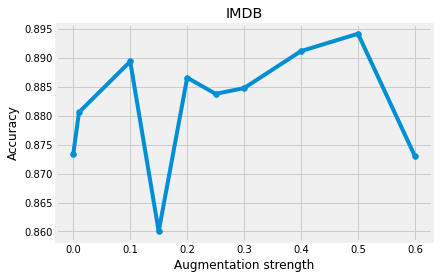

In [3]:
accuracies = [0.8734, 0.8806, 0.8894, 0.86, 0.8866, 0.8838, 0.8848, 0.8912, 0.8942, 0.873]
FRACTIONS = [0, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
plt.plot(FRACTIONS, accuracies)
plt.scatter(FRACTIONS, accuracies)
plt.title('IMDB')
plt.xlabel('Augmentation strength')
plt.ylabel('Accuracy')
plt.savefig(os.path.join(ROOT_DIR, 'imdb_1000_mlm_insertion_strength.eps'), format='eps', bbox_inches='tight')